In [34]:
import pandas as pd
import numpy as np
import re 
import nltk 
import nltk.corpus
from nltk.corpus import stopwords
from numpy import array

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, LSTM, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Embedding
from sklearn.model_selection import train_test_split

In [3]:
reviews = pd.read_csv("a1_IMDB_Dataset.csv")

In [4]:
reviews.shape

(50000, 2)

In [5]:
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

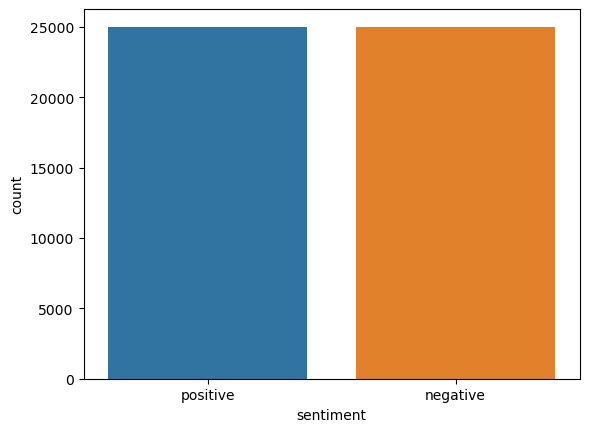

In [7]:
import seaborn as sns
sns.countplot(x='sentiment', data=reviews)

In [8]:
reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [9]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\umuta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    sentence = remove_tags(sentence)

    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [12]:
X = []
sentences = list(reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [13]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [14]:
y = reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=='positive' else 0, y)))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [17]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

92394

In [18]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [19]:
from numpy import asarray
from numpy import zeros

embeddings = dict()
glove = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove:
    records = line.split()
    word = records[0]
    vector = asarray(records[1:], dtype='float32')
    embeddings [word] = vector
glove.close()

In [20]:
matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embeddingVector = embeddings.get(word)
    if embeddingVector is not None:
        matrix[index] = embeddingVector

In [21]:
matrix.shape

(92394, 100)

In [22]:
snn_model = Sequential()
layer = Embedding(vocab_length, 100, weights = [matrix], input_length =maxlen, trainable=False)
snn_model.add(layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [23]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [24]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 1s 4ms/step - loss: 0.5586 - acc: 0.7149 - val_loss: 0.5098 - val_acc: 0.7592
Epoch 2/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4491 - acc: 0.7969 - val_loss: 0.4904 - val_acc: 0.7707
Epoch 3/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4129 - acc: 0.8151 - val_loss: 0.5074 - val_acc: 0.7638
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3903 - acc: 0.8291 - val_loss: 0.5054 - val_acc: 0.7665
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3751 - acc: 0.8346 - val_loss: 0.5193 - val_acc: 0.7598
Epoch 6/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3618 - acc: 0.8445 - val_loss: 0.5302 - val_acc: 0.7594


In [26]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 0s 1ms/step - loss: 0.5567 - acc: 0.7509


In [27]:
print("Test score:", score[0])
print("Test accuracy:", score[1])

Test score: 0.5567261576652527
Test accuracy: 0.7508999705314636


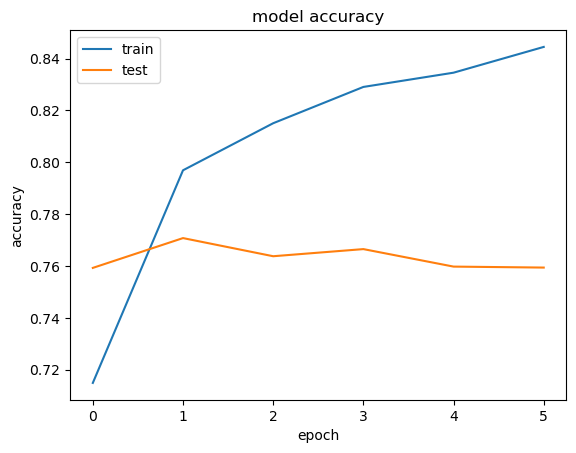

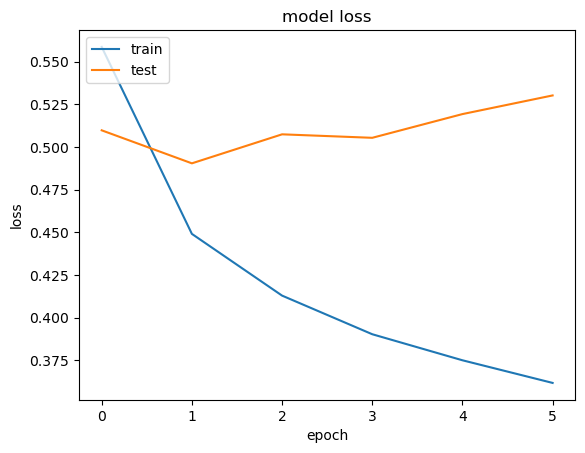

In [29]:
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
from keras.layers import Conv1D

In [35]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [36]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [37]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 6s 23ms/step - loss: 0.4729 - acc: 0.7694 - val_loss: 0.3774 - val_acc: 0.8364
Epoch 2/6
250/250 [==============================] - 5s 22ms/step - loss: 0.3388 - acc: 0.8569 - val_loss: 0.3461 - val_acc: 0.8525
Epoch 3/6
250/250 [==============================] - 5s 22ms/step - loss: 0.2841 - acc: 0.8854 - val_loss: 0.3349 - val_acc: 0.8586
Epoch 4/6
250/250 [==============================] - 5s 22ms/step - loss: 0.2380 - acc: 0.9126 - val_loss: 0.3322 - val_acc: 0.8569
Epoch 5/6
250/250 [==============================] - 5s 22ms/step - loss: 0.1991 - acc: 0.9336 - val_loss: 0.3376 - val_acc: 0.8551
Epoch 6/6
250/250 [==============================] - 5s 22ms/step - loss: 0.1624 - acc: 0.9520 - val_loss: 0.3516 - val_acc: 0.8506


In [38]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 4ms/step - loss: 0.3520 - acc: 0.8493


In [39]:
print("Test Score:", score[0])
print("Test Accuracy", score[1])

Test Score: 0.3520226776599884
Test Accuracy 0.8493000268936157


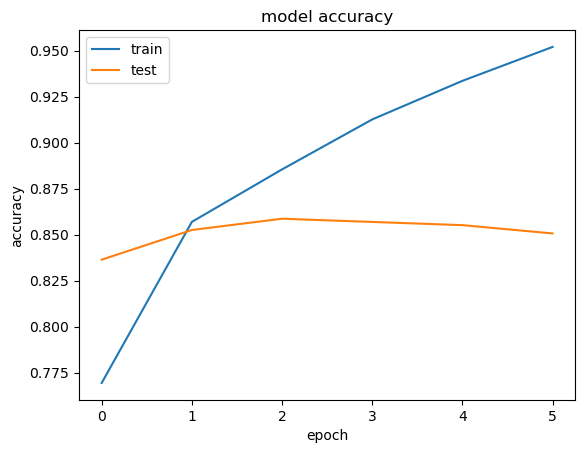

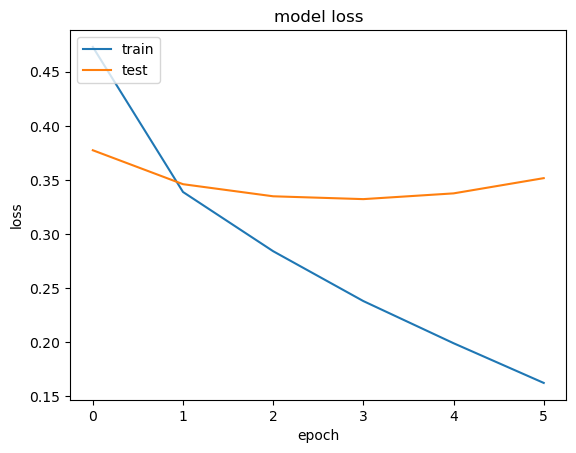

In [40]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [42]:
from keras.layers import LSTM

In [44]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [45]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [46]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 38s 148ms/step - loss: 0.5136 - acc: 0.7501 - val_loss: 0.4495 - val_acc: 0.8037
Epoch 2/6
250/250 [==============================] - 36s 142ms/step - loss: 0.4154 - acc: 0.8135 - val_loss: 0.3824 - val_acc: 0.8357
Epoch 3/6
250/250 [==============================] - 36s 143ms/step - loss: 0.3718 - acc: 0.8389 - val_loss: 0.3722 - val_acc: 0.8485
Epoch 4/6
250/250 [==============================] - 36s 144ms/step - loss: 0.3478 - acc: 0.8524 - val_loss: 0.3532 - val_acc: 0.8604
Epoch 5/6
250/250 [==============================] - 36s 144ms/step - loss: 0.3252 - acc: 0.8636 - val_loss: 0.3188 - val_acc: 0.8680
Epoch 6/6
250/250 [==============================] - 37s 149ms/step - loss: 0.3091 - acc: 0.8717 - val_loss: 0.3312 - val_acc: 0.8587


In [47]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 7s 22ms/step - loss: 0.3355 - acc: 0.8579


In [48]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3354926109313965
Test Accuracy: 0.8579000234603882


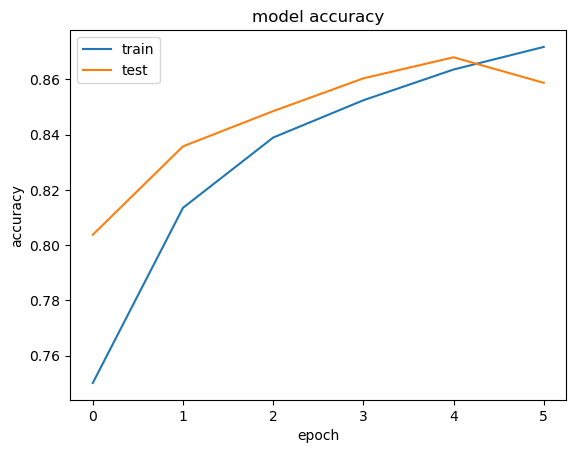

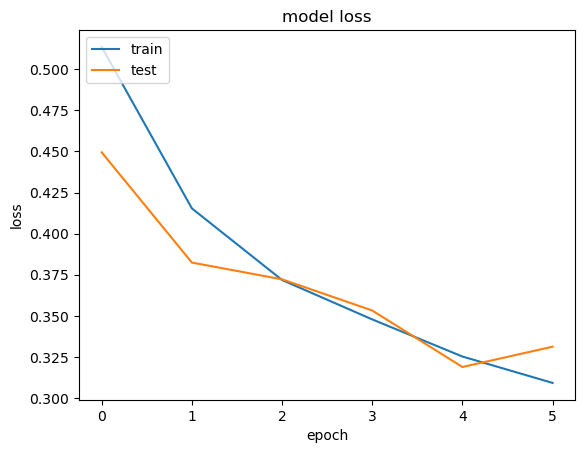

In [49]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [50]:
lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

C:\Users\umuta\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
sample_reviews = pd.read_csv("a3_IMDB_Unseen_Reviews.csv")

sample_reviews.head()

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10


In [53]:
unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
    review = preprocess_text(review)
    unseen_processed.append(review)

In [55]:
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen= maxlen)

In [56]:
unseen_sentiments = lstm_model.predict(unseen_padded)
unseen_sentiments

1/1 [==============================] - 0s 361ms/step


array([[0.8880088 ],
       [0.98948044],
       [0.06809626],
       [0.6887898 ],
       [0.962658  ],
       [0.00536445]], dtype=float32)

In [62]:
sample_reviews['Predicted Rating'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Rating'], columns= ['Predicted Rating'])
df_movie = pd.DataFrame(sample_reviews['Movie'], columns= ['Movie'])
df_review_text = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])

dfx = pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)
dfx.to_csv("c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head()

,Movie,Review Text,IMDb Rating,Predicted Rating
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.9
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.7
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,6.9
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.6
